# Set Up Environment

Import Libraries

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from google.colab import drive
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import plotly.express as px
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk.translate.bleu_score as bleu
from collections import defaultdict
from collections import Counter
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

Visualization Setting

In [ ]:
rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')

Access Data

In [ ]:
path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQUXVEUnbRHtiF75LqxFCldpNmvJHxsZuw9ylLosGvPHEo_f_Fp5r_3c9oabvz2U_UaewWWVx75dx1d/pub?gid=1359530616&single=true&output=csv"
df = pd.read_csv(path, index_col=[0])

In [ ]:
df.head(3)

,question,answer,line,saved,type,saved.question,saved.type,book_id,book_name,chapters.chapter_name
0,Net income under _____________ is unaffected...,Variable Costing,Net income under variable costing is unaffecte...,True,Keyphrase,Net income under variable costing&nbsp;is unaf...,Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...
1,A _____________ is an authorization form pre...,Voucher,A voucher is an authorization form prepared fo...,True,Keyphrase,A(n) _____________ is an authorization form pr...,Keyphrase,120,Accounts,"Chapter 7: Fraud, Internal Control, and Cash"
2,"In contrast, under _____________ , all fixed ...",Variable Costing,"In contrast, under variable costing, all fixed...",True,Keyphrase,"Under ____________ costing, all ____________ m...",Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...


In [ ]:
df.describe()

,book_id
count,16679.000000
mean,126.283710
std,6.274478
min,120.000000
25%,120.000000
50%,121.000000
75%,133.000000
max,134.000000


In [ ]:
df.shape

(16679, 10)

# Phase 1 - Exploratary Data Analysis

## Overview

In [ ]:
print('Shape of dataset: ',df.shape)
df.head()

Shape of dataset:  (16679, 10)


,question,answer,line,saved,type,saved.question,saved.type,book_id,book_name,chapters.chapter_name
0,Net income under _____________ is unaffected...,Variable Costing,Net income under variable costing is unaffecte...,True,Keyphrase,Net income under variable costing&nbsp;is unaf...,Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...
1,A _____________ is an authorization form pre...,Voucher,A voucher is an authorization form prepared fo...,True,Keyphrase,A(n) _____________ is an authorization form pr...,Keyphrase,120,Accounts,"Chapter 7: Fraud, Internal Control, and Cash"
2,"In contrast, under _____________ , all fixed ...",Variable Costing,"In contrast, under variable costing, all fixed...",True,Keyphrase,"Under ____________ costing, all ____________ m...",Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...
3,It is an earnings amount calculated as net inc...,Stock,It is an earnings amount calculated as net inc...,True,Keyphrase,_____________ is the amount calculated as net ...,Keyphrase,120,Accounts,Chapter 2: A Further Look at Financial Statements
4,"For example, Nike golf clubs are sold at local...",What's Cooking?,"For example, Nike golf clubs are sold at local...",True,Example,"When the due date is stated in months, the tim...",Example,120,Accounts,Chapter 8: Reporting and Analyzing Receivables


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16679 entries, 0 to 16678
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               16679 non-null  object
 1   answer                 16624 non-null  object
 2   line                   16679 non-null  object
 3   saved                  16679 non-null  bool  
 4   type                   16679 non-null  object
 5   saved.question         1646 non-null   object
 6   saved.type             1646 non-null   object
 7   book_id                16679 non-null  int64 
 8   book_name              16679 non-null  object
 9   chapters.chapter_name  16679 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.3+ MB


In [ ]:
# Check proportion of SME saved questions
df['saved'].value_counts()

False    15033
True      1646
Name: saved, dtype: int64

In [ ]:
# Numbers of Question in each book
df['book_name'].value_counts()

In [ ]:
# Number of Word in each book
df.groupby('book_name')['len_q'].sum()

## Visualization

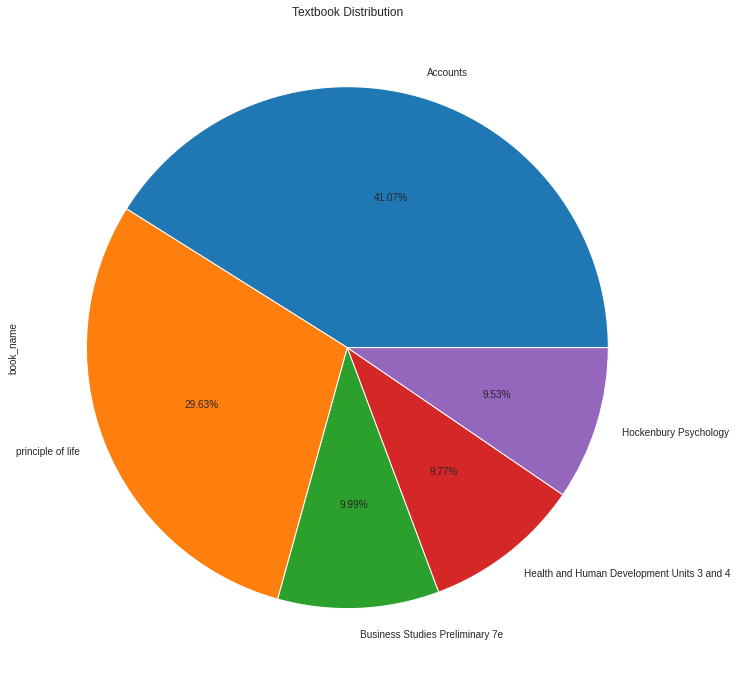

In [ ]:
book_acc = df.book_name.value_counts()
book_acc.plot(kind = 'pie', title = 'Textbook Distribution', figsize=[12,12],
          autopct=lambda p: '{:.2f}%'.format(p))
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

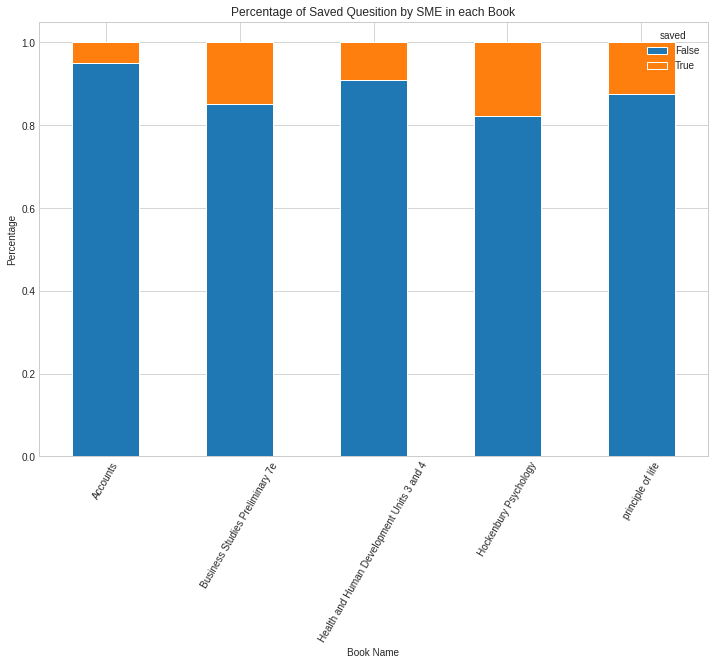

In [ ]:
# Draw stack bar char of book name cut by saved
table_book = pd.crosstab(df.book_name,df.saved)
table_book.div(table_book.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Percentage of Saved Quesition by SME in each Book')
plt.xlabel('Book Name')
plt.ylabel('Percentage')
plt.xticks(rotation = 60)

In [ ]:
# Pie Chart
total = len(df)
key = len(df[df['type']=='Keyphrase']) / total *100
ex = len(df[df['type']=='Example']) / total *100

# Percentage of subgroup
keyS = len(df.loc[(df['type']=='Keyphrase') & (df['saved']==True)]) / total *100
keyNS = len(df.loc[(df['type']=='Keyphrase') & (df['saved']==False)]) / total *100
exS = len(df.loc[(df['type']=='Example') & (df['saved']==True)]) / total *100
exNS = len(df.loc[(df['type']=='Example') & (df['saved']==False)]) / total *100

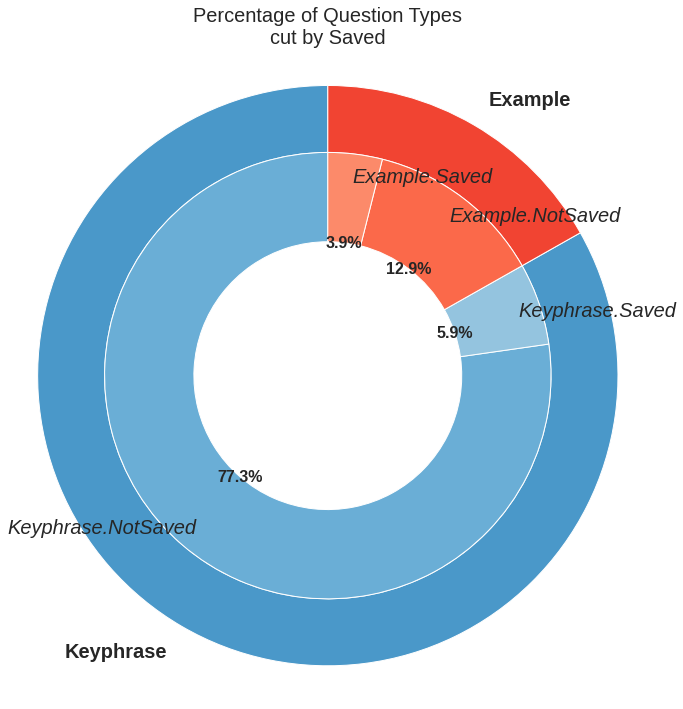

In [ ]:
# Lists of groups name and values 
group_names = ['Keyphrase','Example']
group_size = [key,ex]
subgroup_names = ['Keyphrase.NotSaved', 'Keyphrase.Saved', 'Example.NotSaved', 'Example.Saved']
subgroup_size = [keyNS,keyS,exNS,exS]
 
# Create colors
a, b = [plt.cm.Blues, plt.cm.Reds]
 
# First Ring(outside)
fig, ax = plt.subplots(figsize = (10,12))
ax.axis('equal')
mypie,texts = ax.pie(group_size, radius=1.3, labels = group_names, 
                     colors = [a(0.6), b(0.6)], startangle=90)
plt.setp(mypie,width = 0.3,edgecolor = 'white')
plt.setp(texts,size = 20,weight = 'bold')

# Second Ring(Inside)
mypie2,texts2,autotexts2 = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.9, 
                                  colors=[a(0.5), a(0.4), b(0.5), b(0.4)],autopct='%1.1f%%', startangle=90)
plt.setp(mypie2, width=0.4, edgecolor='white')
plt.setp(texts2,size = 20, style='italic')
plt.setp(autotexts2,size = 16,weight = 'bold')
plt.margins(0,0)

# Set up the title
plt.title('Percentage of Question Types\ncut by Saved',size = 20)

# Show it
plt.show()

In [ ]:
# Copy dataset
df1 = df.copy()

In [ ]:
# Count length of sentense
df1["len_q"] = df1["question"].apply(lambda x: len(x.split()))
df1['saved.question'] = df1['saved.question'].fillna("")
df1["len_sq"] = df1["saved.question"].apply(lambda x: len(x.split()))

Text(0.5, 0, 'Length of Question')

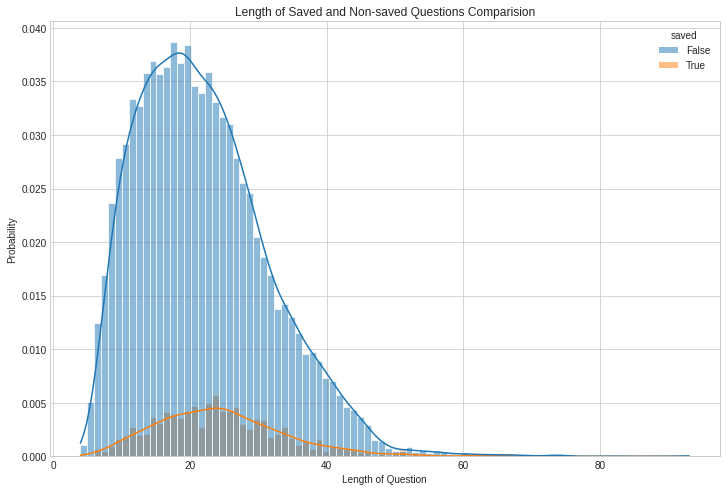

In [ ]:
# Histogram of Sentense Length
sns.histplot(df1, x="len_q",stat="probability",hue='saved',kde=True).set(title = 'Length of Saved and Non-saved Questions Comparision')
plt.xlabel('Length of Question')

In [ ]:
len_sq_edit = df1['len_sq'].tolist()
len_sq_edit = [i for i in len_sq_edit if i != 0]
len_sq_ori = df1.loc[df1['saved'] == True,'len_q']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


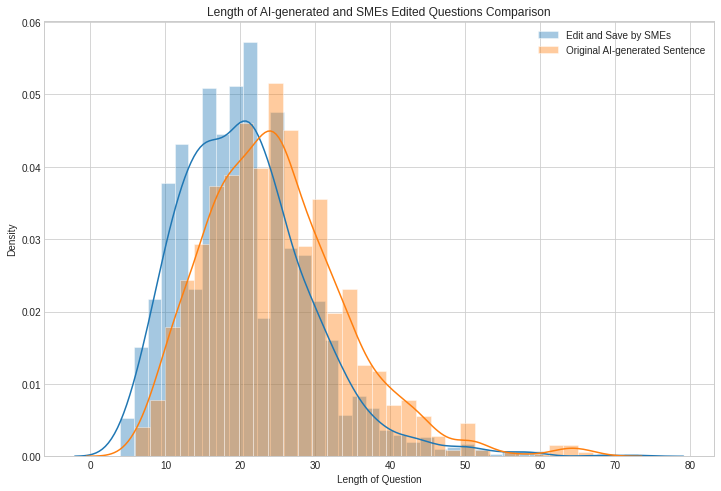

In [ ]:
ax1 = sns.distplot(len_sq_edit, label = 'Edit and Save by SMEs').get_lines()[0].get_data()
ax2 = sns.distplot(len_sq_ori, label='Original AI-generated Sentence').get_lines()[0].get_data()
plt.legend()
plt.title('Length of AI-generated and SMEs Edited Questions Comparison')
plt.xlabel('Length of Question') 
plt.show()

In [ ]:
# Split punctuation
#https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
def create_corpus(target):
    corpus=[]
    for x in df1[df1['saved']==target]['question'].str.split():
      for i in x :
        corpus.append(i)
    return corpus

In [ ]:
# Create punctuation dictionary
punct = string.punctuation
def punctuation_count(corpus):
  dd = defaultdict(int)
  for i in (corpus):
    if i in punct:
      dd[i]+=1
  return dd

In [ ]:
saved_corpus = create_corpus(1)
nsaved_corpus = create_corpus(0)
dd_s = punctuation_count(saved_corpus)
dd_ns =punctuation_count(nsaved_corpus)

In [ ]:
t1 = pd.DataFrame.from_dict(dd_s, orient='index',columns = ['saved'])
t2 = pd.DataFrame.from_dict(dd_ns, orient='index',columns = ['not_saved'])
punct_df = pd.concat([t1,t2],axis = 1)
punct_df = punct_df.fillna(0)
punct_df['saved'] = punct_df['saved'].astype(int)
punct_df = punct_df.sort_values(by=['not_saved'],ascending=False)
punct_df.reset_index(inplace=True)
punct_df = punct_df.rename(columns = {'index':'punctuation'})
punct_df

,punctuation,saved,not_saved
0,.,389,3538
1,",",190,2421
2,$,0,253
3,+,24,195
4,=,6,172
5,?,1,164
6,:,5,121
7,;,3,46
8,',1,15
9,&,1,15


In [ ]:
punct_df['saved_den'] = punct_df['saved'].apply(lambda x: x/sum(punct_df['saved']))
punct_df['not_saved_den'] = punct_df['not_saved'].apply(lambda x: x/sum(punct_df['not_saved']))

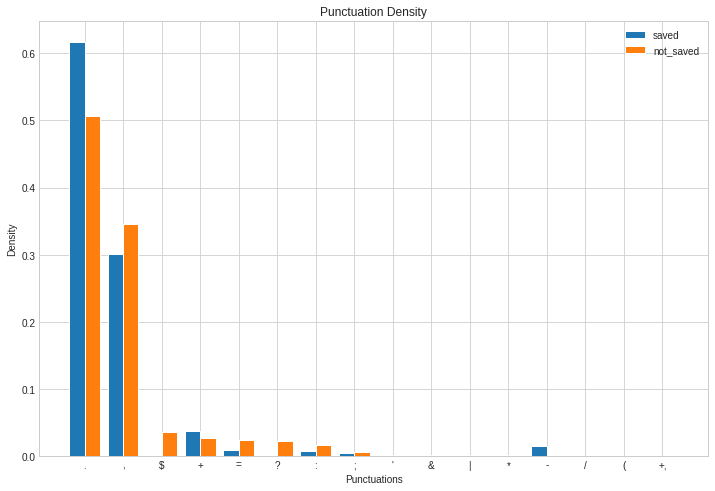

In [ ]:
X_axis = np.arange(len(punct_df))
plt.bar(X_axis - 0.2, punct_df['saved_den'], 0.4, label = 'saved')
plt.bar(X_axis + 0.2,  punct_df['not_saved_den'], 0.4, label = 'not_saved')
plt.xticks(X_axis, punct_df['punctuation'])
plt.xlabel("Punctuations")
plt.ylabel("Density")
plt.title("Punctuation Density")
plt.legend()
plt.show()

## Data cleaning

In [ ]:
df_copy = df.copy()

In [ ]:
# Make it lowercase and remove unnecessary punctuation
# https://www.kaggle.com/tanulsingh077
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('&nbsp', ' ', text) #error in 'saved.question'
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df_copy['q_clean'] = df_copy['question'].apply(clean_text)
df_copy['saved_q_clean'] = df_copy['saved.question'].apply(clean_text)

In [ ]:
nltk.download('stopwords')
# Reomove stopwords
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_copy['q_clean'] = df_copy['q_clean'].apply(remove_stopwords)
df_copy['saved_q_clean'] = df_copy['saved_q_clean'].apply(remove_stopwords)
df_copy['q_clean'].unique()
df_copy['saved_q_clean'].unique()

array(['net income variable costingnbspis unaffected changes production levelsnbspnet income variable costing unaffected changes production levels instead closely tied changes ',
       ' authorization form prepared expenditure',
       ' costing  manufacturing costs expensed current period', ...,
       ' doublestranded molecule—that consists two separate  strands length',
       'atom consists nucleus containing  characteristic configuration nbspin orbitals around nucleus',
       'image numbered boxes bandnbsp'], dtype=object)

## Target Variabl Encoding

In [ ]:
le = LabelEncoder()
le.fit(df_copy['saved']) # target variable='saved'

df_copy['saved_encoded'] = le.transform(df_copy['saved'])
df_copy.head()

,question,answer,line,saved,type,saved.question,saved.type,book_id,book_name,chapters.chapter_name,q_clean,saved_q_clean,saved_encoded
0,Net income under _____________ is unaffected...,Variable Costing,Net income under variable costing is unaffecte...,True,Keyphrase,Net income under variable costing&nbsp;is unaf...,Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...,net income unaffected changes production le...,net income variable costingnbspis unaffected c...,1
1,A _____________ is an authorization form pre...,Voucher,A voucher is an authorization form prepared fo...,True,Keyphrase,A(n) _____________ is an authorization form pr...,Keyphrase,120,Accounts,"Chapter 7: Fraud, Internal Control, and Cash",authorization form prepared expenditure,authorization form prepared expenditure,1
2,"In contrast, under _____________ , all fixed ...",Variable Costing,"In contrast, under variable costing, all fixed...",True,Keyphrase,"Under ____________ costing, all ____________ m...",Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...,contrast fixed manufacturing costs expensed...,costing manufacturing costs expensed current...,1
3,It is an earnings amount calculated as net inc...,Stock,It is an earnings amount calculated as net inc...,True,Keyphrase,_____________ is the amount calculated as net ...,Keyphrase,120,Accounts,Chapter 2: A Further Look at Financial Statements,earnings amount calculated net income less div...,amount calculated net income less dividends p...,1
4,"For example, Nike golf clubs are sold at local...",What's Cooking?,"For example, Nike golf clubs are sold at local...",True,Example,"When the due date is stated in months, the tim...",Example,120,Accounts,Chapter 8: Reporting and Analyzing Receivables,example nike golf clubs sold local country clu...,due date stated months time factor calculation...,1


In [ ]:
def get_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def get_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0.5, 0, 'Count')

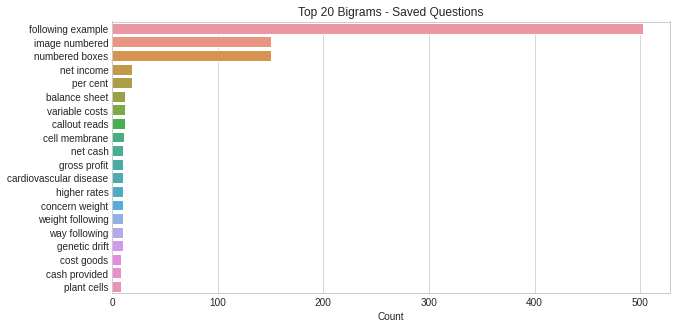

In [ ]:
plt.figure(figsize=(10,5))
top_20_bigrams=get_bigrams(df_copy.loc[df_copy['saved_encoded'] == True, 'q_clean'])[:20]
x,y=map(list,zip(*top_20_bigrams))
sns.barplot(x=y,y=x)
plt.title('Top 20 Bigrams - Saved Questions')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

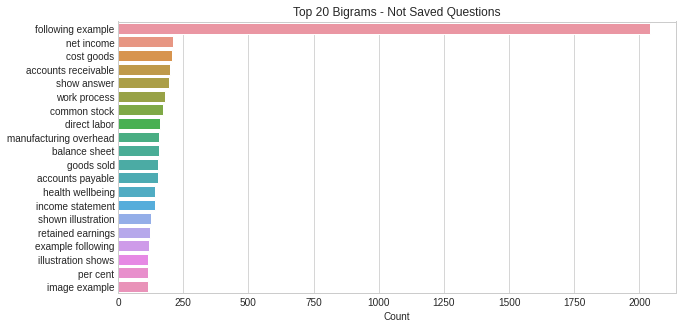

In [ ]:
plt.figure(figsize=(10,5))
top_20_bigrams=get_bigrams(df_copy.loc[df_copy['saved_encoded'] == False, 'q_clean'])[:20]
x,y=map(list,zip(*top_20_bigrams))
sns.barplot(x=y,y=x)
plt.title('Top 20 Bigrams - Not Saved Questions')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

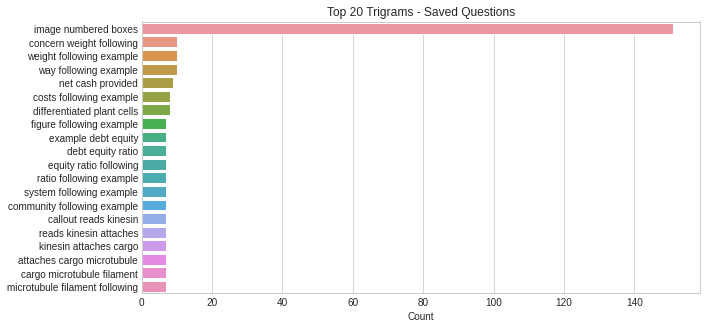

In [ ]:
plt.figure(figsize=(10,5))
top_20_trigrams=get_trigrams(df_copy.loc[df_copy['saved_encoded'] == True, 'q_clean'])[:20]
x,y=map(list,zip(*top_20_trigrams))
sns.barplot(x=y,y=x)
plt.title('Top 20 Trigrams - Saved Questions')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

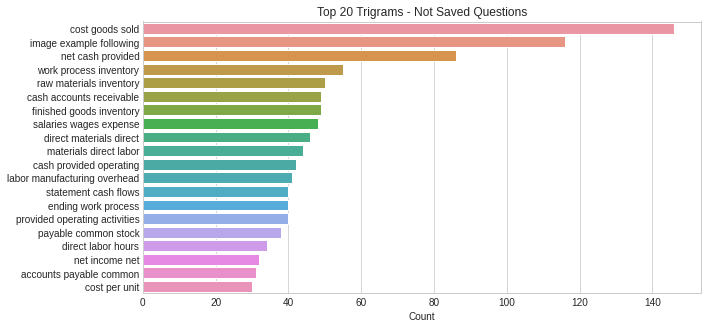

In [ ]:
plt.figure(figsize=(10,5))
top_20_trigrams=get_trigrams(df_copy.loc[df_copy['saved_encoded'] == False, 'q_clean'])[:20]
x,y=map(list,zip(*top_20_trigrams))
sns.barplot(x=y,y=x)
plt.title('Top 20 Trigrams - Not Saved Questions')
plt.xlabel('Count')

Sentiment Analysis

In [ ]:
# Calculate polarirty and subjectivity
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df_copy[['polarity', 'subjectivity']] = df_copy['q_clean'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(df_copy['question']):
  ps = sia.polarity_scores(s)
  df_copy.loc[index,['neg']] = ps['neg']
  df_copy.loc[index,['neu']] = ps['neu']
  df_copy.loc[index,['pos']] = ps['pos']
  df_copy.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    df_copy.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    df_copy.loc[index,['sentiment']] = 'positive'
  else:
    df_copy.loc[index,['sentiment']] = 'neutral'
   
df_copy.head(10)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,question,answer,line,saved,type,saved.question,saved.type,book_id,book_name,chapters.chapter_name,q_clean,saved_q_clean,saved_encoded,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,Net income under _____________ is unaffected...,Variable Costing,Net income under variable costing is unaffecte...,True,Keyphrase,Net income under variable costing&nbsp;is unaf...,Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...,net income unaffected changes production le...,net income variable costingnbspis unaffected c...,1,-0.025000,0.050000,0.0,1.000,0.000,0.0000,neutral
1,A _____________ is an authorization form pre...,Voucher,A voucher is an authorization form prepared fo...,True,Keyphrase,A(n) _____________ is an authorization form pr...,Keyphrase,120,Accounts,"Chapter 7: Fraud, Internal Control, and Cash",authorization form prepared expenditure,authorization form prepared expenditure,1,0.000000,0.000000,0.0,0.808,0.192,0.2263,positive
2,"In contrast, under _____________ , all fixed ...",Variable Costing,"In contrast, under variable costing, all fixed...",True,Keyphrase,"Under ____________ costing, all ____________ m...",Keyphrase,120,Accounts,Chapter 19 Cost-Volume-Profit Analysis: Additi...,contrast fixed manufacturing costs expensed...,costing manufacturing costs expensed current...,1,0.050000,0.300000,0.0,1.000,0.000,0.0000,neutral
3,It is an earnings amount calculated as net inc...,Stock,It is an earnings amount calculated as net inc...,True,Keyphrase,_____________ is the amount calculated as net ...,Keyphrase,120,Accounts,Chapter 2: A Further Look at Financial Statements,earnings amount calculated net income less div...,amount calculated net income less dividends p...,1,-0.083333,0.033333,0.0,1.000,0.000,0.0000,neutral
4,"For example, Nike golf clubs are sold at local...",What's Cooking?,"For example, Nike golf clubs are sold at local...",True,Example,"When the due date is stated in months, the tim...",Example,120,Accounts,Chapter 8: Reporting and Analyzing Receivables,example nike golf clubs sold local country clu...,due date stated months time factor calculation...,1,0.033333,0.166667,0.0,1.000,0.000,0.0000,neutral
5,a $450 payment on _____________ is debited t...,Account,a $450 payment on account is debited to Accoun...,True,Keyphrase,Paying an account payable with cash affects th...,Keyphrase,120,Accounts,Chapter 3: The Accounting Information System,payment debited accounts payable credited...,paying account payable cash affects components...,1,0.000000,0.000000,0.0,0.865,0.135,0.3612,positive
6,"<p><img src=""http://aiassessment.s3-website-us...",2,"<p><img src=""http://aiassessment.s3-website-us...",True,Example,"<p><img alt=""question image"" src=""http://aiass...",Example,120,Accounts,Chapter 8: Reporting and Analyzing Receivables,image numbered boxes due date,image numbered boxes due date,1,-0.125000,0.375000,0.0,1.000,0.000,0.0000,neutral
7,The system of collecting and processing transa...,Accounting Information System,The system of collecting and processing transa...,True,Keyphrase,The system that collects and processes transac...,Keyphrase,120,Accounts,Chapter 3: The Accounting Information System,system collecting processing transaction data ...,system collects processes transaction data com...,1,0.000000,0.000000,0.0,1.000,0.000,0.0000,neutral
8,The _____________ are activities undertaken ...,Cost Drivers,The cost drivers are activities undertaken to ...,True,Keyphrase,"Number of purchase orders, number of setups, l...",Keyphrase,120,Accounts,Chapter 17 Activity-Based Costing,activities undertaken produce goods perform...,number purchase orders number setups labor hou...,1,0.000000,0.000000,0.0,1.000,0.000,0.0000,neutral
9,"Grocery stores, therefore, focus on asset turn...",Increase,"Grocery stores, therefore, focus on asset turn...",True,Keyphrase,Expenditures to maintain the operating efficie...,Keyphrase,120,Accounts,Chapter 9: Reporting and Analyzing Long-Lived ...,grocery stores therefo

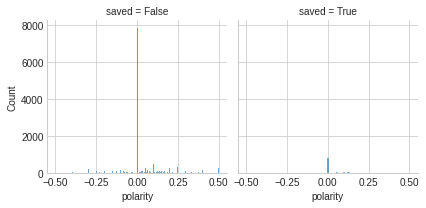

In [ ]:
g = sns.FacetGrid(df_copy, col="saved")
g.map(sns.histplot, "polarity", binrange=(-0.5, 0.5))

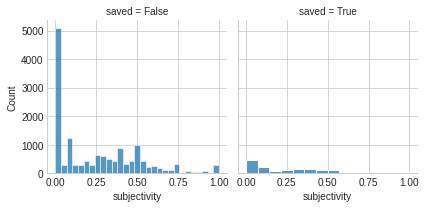

In [ ]:
g = sns.FacetGrid(df_copy, col="saved")
g.map(sns.histplot, "subjectivity")

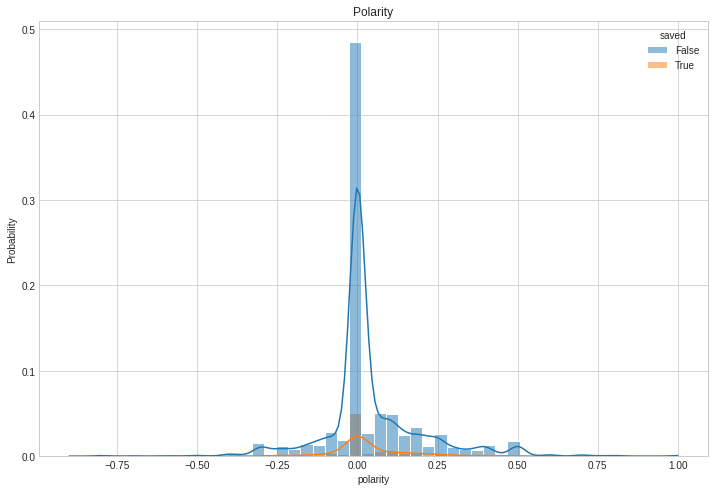

In [ ]:
# Histomgrams of polarity
n_bins = 50
ax = sns.histplot(df_copy,x = 'polarity',stat = 'probability',hue = 'saved',kde = True, bins = n_bins)
ax.set_title('Polarity')
plt.show()

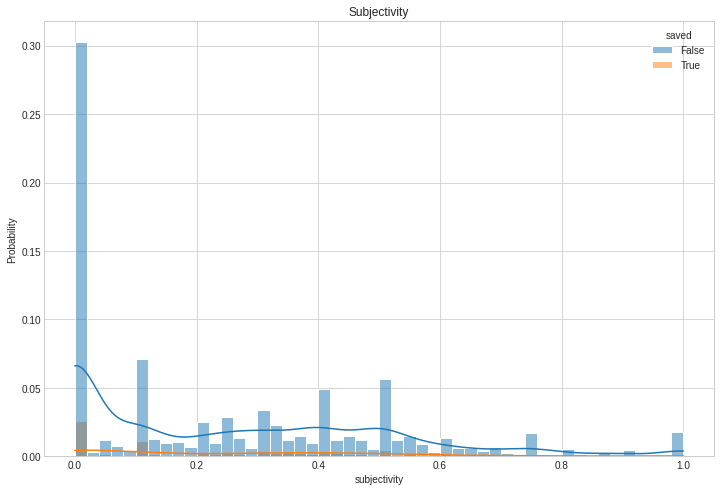

In [ ]:
# Histomgrams of subjectivity
n_bins = 50
ax = sns.histplot(df_copy,x = 'subjectivity',stat = 'probability',hue = 'saved',kde = True, bins = n_bins)
ax.set_title('Subjectivity')
plt.show()

# Phase 2 - Modeling

## Train and Test Split

train/test split -> tokenization -> word embedding -> build model

In [ ]:
# Keras
import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D,
                          CuDNNLSTM,Flatten,
                          SpatialDropout1D)

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

np.random.seed(2) # make the result reproducible
tf.random.set_seed(1234)
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# Assign X and y
x = df_copy['q_clean']
y = df_copy['saved_encoded']

In [ ]:
# Check the dataset imbalance:
F, T = np.bincount(df_copy['saved_encoded'])
total = F + T
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, T, 100 * T / total))

Examples:
    Total: 16679
    Positive: 1646 (9.87% of total)



In [ ]:
# Upsampling the 1s
# https://www.kaggle.com/code/camnugent/class-imbalance-a-lesson-learned-tensorflow-nn/notebook#5.-Solution-B:-Upsampling-the-1s
df_copy_false = df_copy[df_copy['saved_encoded'] == 0]
df_copy_true = df_copy[df_copy['saved_encoded'] == 1]
rep_1 =[df_copy_true for x in range(df_copy_false.shape[0]//df_copy_true.shape[0] )]
keep_1s = pd.concat(rep_1, axis=0)
# Create a balanced dataset
df_copy_balanced = pd.concat([keep_1s,df_copy_false],axis=0)

In [ ]:
# Check the dataset imbalance:
F, T = np.bincount(df_copy_balanced ['saved_encoded'])
total = F + T
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, T, 100 * T / total))

Examples:
    Total: 29847
    Positive: 14814 (49.63% of total)



In [ ]:
# Assign X and y
x = df_copy_balanced['q_clean']
y = df_copy_balanced['saved_encoded']

In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #42

In [ ]:
x_train

12918    bottom half diverges isometopids     lineage h...
6871        business depends ability develop use asset ...
12181                          adults    tunicates sessile
15792              arrow r n labeled    points polypeptide
11842                       image numbered boxes estradiol
                               ...                        
16634    cat three kittens—one orange one gray one blac...
6955     fair work commission power resolve industrial ...
10263    another important hormone oxytocin  hormone in...
1328     ledger chart accounts    recording process ill...
9584     explain three reasons safe    essential human ...
Name: q_clean, Length: 19400, dtype: object

## Tokenization for LSTM

In [ ]:
# words embedding
max_length=100
words=20000

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(x_train)
x_train_RNN = tokenizer.texts_to_sequences(x_train)
x_test_RNN = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(len(x_train_RNN))
print(len(x_test_RNN))

20892
8955


In [ ]:
# Padding the Text -> make each sentence have same length
x_train_RNN = tf.keras.preprocessing.sequence.pad_sequences(x_train_RNN, maxlen=max_length)
x_test_RNN = tf.keras.preprocessing.sequence.pad_sequences(x_test_RNN, maxlen=max_length)

In [ ]:
print(len(x_train_RNN))
print(x_train_RNN[0, :])

20892
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  530 1759  236 1760 2907
 1178   75]


In [ ]:
# Number of unique words
word_index = tokenizer.word_index
word_size = len(tokenizer.word_index) + 1  
word_size

14496

## Word Embedding

In [ ]:
## Downloading Glove Embedding
# https://colab.research.google.com/drive/1mvY1vFMvMnUIbC8hvHvlm-UeSeSAlil9#scrollTo=SLaROjMvJg2X 
# https://nlp.stanford.edu/projects/glove/
!wget http://nlp.stanford.edu/data/glove.6B.zip
!apt install unzip
!unzip "glove.6B.zip"

--2022-05-10 22:21:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-10 22:21:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-10 22:21:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!python -m gensim.scripts.glove2word2vec -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'gensim.scripts.glove2word2vec' found in sys.modules after import of package 'gensim.scripts', but prior to execution of 'gensim.scripts.glove2word2vec'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-05-10 22:21:14,836 - glove2word2vec - INFO - running /usr/local/lib/python3.7/dist-packages/gensim/scripts/glove2word2vec.py -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/gensim/scripts/glove2word2vec.py", line 122, in <module>
    num_lines, num_dims = glove2word2vec(args.input, args.output)
  File "/usr/local/lib/python3.7/dist-packages/gensim/scripts/glove2word2vec.py", line 104, in glove2word2vec
    num_lines, num_dims = get_glove_info(glov

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import os
import glob
os.listdir()

['.config', 'sample_data']

In [ ]:
'''
## Convert Glove Embedding to Word2Vec Embedding
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt',binary=False)
# Example for Word2Vec
w2v.most_similar('college')
'''

In [ ]:
# https://www.kaggle.com/code/arunrk7/nlp-beginner-text-classification-using-lstm#Text-Preprocessing
EMBEDDING_FILE = 'glove.6B.300d.txt'
# 'Converted model with 400000 vectors and 300 dimensions'
embeddings_dim = 300
embeddings_index = {}

f = open(EMBEDDING_FILE)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((word_size, embeddings_dim)) #vocab_size=word_size
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape[0]

14496

## Building LSTM

In [ ]:
'''
# Initiate model
question_RNN_model=tf.keras.Sequential()
# Embedding Layer
#question_RNN_model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(x_train_RNN.shape[1],)))
question_RNN_model.add(tf.keras.layers.Embedding(word_size, embeddings_dim, 
                                                 weights=[embedding_matrix], input_length=max_length, trainable=False))
question_RNN_model.add(tf.keras.layers.SpatialDropout1D(0.3))
# LSTM Layer
#question_RNN_model.add(tf.keras.layers.Bidirectional(LSTM(units=128))) #activation='tanh' or 'ReLU' needed?
question_RNN_model.add(tf.keras.layers.Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
question_RNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
question_RNN_model.add(tf.keras.layers.Dropout(0.5))  
# Output Layer
question_RNN_model.add(tf.keras.layers.Dense(units=16, activation='relu')) 
question_RNN_model.add(tf.keras.layers.Dropout(0.5))  
question_RNN_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

question_RNN_model.summary()
'''

"\n# Initiate model\nquestion_RNN_model=tf.keras.Sequential()\n# Embedding Layer\n#question_RNN_model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(x_train_RNN.shape[1],)))\nquestion_RNN_model.add(tf.keras.layers.Embedding(word_size, embeddings_dim, \n                                                 weights=[embedding_matrix], input_length=max_length, trainable=False))\nquestion_RNN_model.add(tf.keras.layers.SpatialDropout1D(0.3))\n# LSTM Layer\n#question_RNN_model.add(tf.keras.layers.Bidirectional(LSTM(units=128))) #activation='tanh' or 'ReLU' needed?\nquestion_RNN_model.add(tf.keras.layers.Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))\nquestion_RNN_model.add(tf.keras.layers.GlobalMaxPooling1D())\nquestion_RNN_model.add(tf.keras.layers.Dropout(0.5))  \n# Output Layer\nquestion_RNN_model.add(tf.keras.layers.Dense(units=16, activation='relu')) \nquestion_RNN_model.add(tf.keras.layers.Dropout(0.5))  \nquestion_RNN_model.add

In [ ]:
# Initiate model
question_RNN_model=tf.keras.Sequential()
# Embedding Layer
question_RNN_model.add(tf.keras.layers.Embedding(word_size, embeddings_dim, 
                                                 weights=[embedding_matrix], 
                                                 input_length=max_length, trainable=False))
question_RNN_model.add(tf.keras.layers.SpatialDropout1D(0.3))
# LSTM Layer
question_RNN_model.add(tf.keras.layers.LSTM(units=128, dropout=0.3, recurrent_dropout=0.3))
# Output Layer
question_RNN_model.add(tf.keras.layers.Dense(units=32, activation='relu')) 
question_RNN_model.add(tf.keras.layers.Dropout(0.5))
question_RNN_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

question_RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          4348800   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 100, 300)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                      

In [ ]:
'''
# Compiling the model
#from tensorflow.keras.optimizers import Adam
question_RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #rmsprop

# configure early stopping
# https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience = 5)
'''

In [ ]:
'''
# Fitting and training the model
# batch_size=128; take 128 sentences and put in one batch
history = question_RNN_model.fit(x_train_RNN, y_train, epochs=20, batch_size=128, verbose = True,
                       validation_data = (x_test_RNN, y_test), callbacks=[es]) 
                       '''

'\n# Fitting and training the model\n# batch_size=128; take 128 sentences and put in one batch\nhistory = question_RNN_model.fit(x_train_RNN, y_train, epochs=20, batch_size=128, verbose = True,\n                       validation_data = (x_test_RNN, y_test), callbacks=[es]) \n                       '

In [ ]:
# Compiling the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
question_RNN_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) #rmsprop

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
# Fitting and training the model
# batch_size=128; take 128 sentences and put in one batch
history = question_RNN_model.fit(x_train_RNN, y_train, epochs=20, batch_size=128, verbose = True,
                       validation_data = (x_test_RNN, y_test), callbacks = [learning_rate_reduction, es]) #callbacks=[es]

Epoch 1/20
164/164 [==============================] - 182s 1s/step - loss: 0.6316 - accuracy: 0.6311 - val_loss: 0.5705 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 2/20
164/164 [==============================] - 177s 1s/step - loss: 0.5776 - accuracy: 0.6791 - val_loss: 0.5354 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 3/20
164/164 [==============================] - 144s 878ms/step - loss: 0.5352 - accuracy: 0.7096 - val_loss: 0.4797 - val_accuracy: 0.7646 - lr: 0.0010
Epoch 4/20
164/164 [==============================] - 144s 876ms/step - loss: 0.4982 - accuracy: 0.7450 - val_loss: 0.4319 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 5/20
164/164 [==============================] - 142s 867ms/step - loss: 0.4509 - accuracy: 0.7800 - val_loss: 0.3812 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 6/20
164/164 [==============================] - 143s 870ms/step - loss: 0.3947 - accuracy: 0.8162 - val_loss: 0.3025 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 7/20
164/164 [==============================] 

adjusting batch_size and epochs.. use callback for optimal epochs. changed trainig size from 0.25 to 0.30

Having a very large epoch size will not necessarily improve your accuracy. Epoch sizes can increase the accuracy up to a certain limit beyond which you begin to overfit your model. Having a very low one will also result in underfitting. See this. So looking at the huge difference between epoch 99 and epoch 100, you can already tell that you are overfitting the model. As a rule of thumb, when you notice the accuracy stops increasing, that is the ideal number of epochs you should have usually between 1 and 10. 100 seems too much already.

Batch size does not affect your accuracy. This is just used to control the speed or performance based on the memory in your GPU. If you have huge memory, you can have a huge batch size so training will be faster.

What you can do to increase your accuracy is: 1. Increase your dataset for the training. 2. Try using Convolutional Networks instead.

In [ ]:
# Check model accuracy on train and test set
train_loss, train_accuracy = question_RNN_model.evaluate(x_train_RNN, y_train, verbose = False)
print("RNN Model Train Accuracy: {:.3f}".format(train_accuracy))
test_loss, test_acurracy = question_RNN_model.evaluate(x_test_RNN, y_test, verbose = False)
print("RNN Model Test accuracy: {:.3f}".format(test_acurracy))

RNN Model Train Accuracy: 0.992
RNN Model Test accuracy: 0.958


In [ ]:
print(history.history.keys())
print(history.history['val_loss'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
[0.5704705715179443, 0.535386323928833, 0.4796837866306305, 0.4319045841693878, 0.38116705417633057, 0.30246806144714355, 0.2556811273097992, 0.23543785512447357, 0.20374904572963715, 0.17804497480392456, 0.2031330019235611, 0.17958664894104004, 0.16314072906970978, 0.17726364731788635, 0.16039784252643585, 0.18244287371635437, 0.17322388291358948, 0.14982442557811737, 0.14345301687717438, 0.1304907500743866]


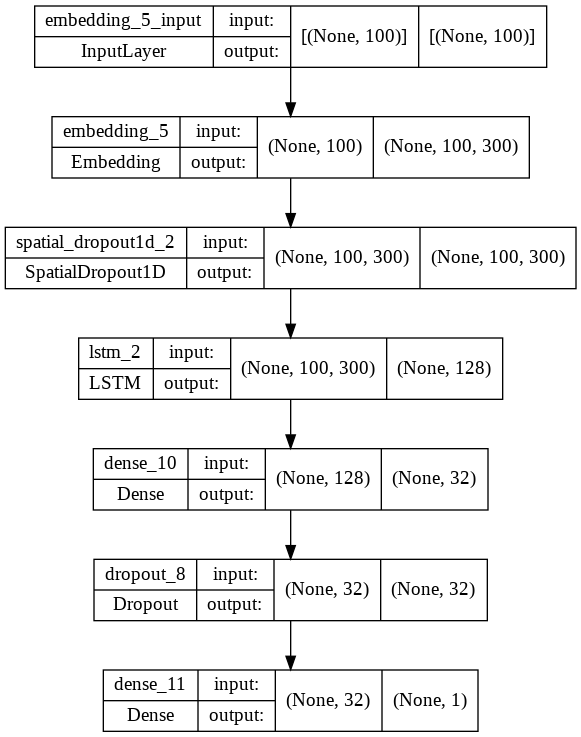

In [ ]:
# summarize the model
from keras.utils.vis_utils import plot_model
plot_model(question_RNN_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Performance Metrics and Accuracy

In [ ]:
# Visualize model training and validation history
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'purple', label='Training acc')
    plt.plot(x, val_acc, 'orange', label='Validation acc')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and validation accuracy \n')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'purple', label='Training loss')
    plt.plot(x, val_loss, 'orange', label='Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training and validation loss \n')
    plt.legend()

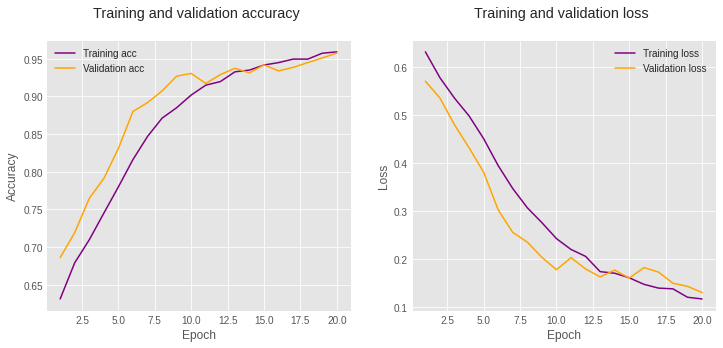

In [ ]:
# create a plot 
plot_history(history)

In [ ]:
# predict 
predictions = (question_RNN_model.predict(x_test_RNN) > 0.5).astype("int32")

In [ ]:
# Build confusion metrix 
from sklearn.metrics import classification_report, confusion_matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

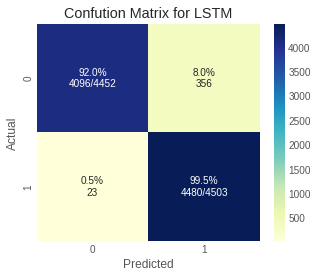

In [ ]:
# Show Confusion Matrix
plot_cm(y_test, predictions, 'Confution Matrix for LSTM')

In [ ]:
# Show classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      4452
           1       0.93      0.99      0.96      4503

    accuracy                           0.96      8955
   macro avg       0.96      0.96      0.96      8955
weighted avg       0.96      0.96      0.96      8955



## Tokenization for CNN


In [ ]:
# words embedding
max_length=100
words=20000

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(x_train)
x_train_CNN = tokenizer.texts_to_sequences(x_train)
x_test_CNN = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(len(x_train_CNN))
print(len(x_test_CNN))

20892
8955


In [ ]:
# Padding the Text -> make each sentence have same length
x_train_CNN = pad_sequences(x_train_CNN, padding='post', maxlen=max_length)
x_test_CNN = pad_sequences(x_test_CNN, padding='post', maxlen=max_length)

In [ ]:
print(len(x_train_CNN))
print(x_train_CNN[0, :])

20892
[ 530 1759  236 1760 2907 1178   75    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
# Number of unique words
word_index = tokenizer.word_index
word_size = len(tokenizer.word_index) + 1  
word_size

14496

## Building CNN

In [ ]:
#fit CNN Model
from keras import layers 

#embedding_dim = 200
question_CNN_model=tf.keras.Sequential()
question_CNN_model.add(layers.Embedding(word_size, embeddings_dim, input_length=max_length))

question_CNN_model.add(layers.Conv1D(64, 3, activation='relu'))
question_CNN_model.add(layers.MaxPooling1D(pool_size=2)) # GlobalMaxPooling1D
question_CNN_model.add(tf.keras.layers.Dropout(0.25)) 
question_CNN_model.add(layers.Flatten())

question_CNN_model.add(layers.Dense(32, activation='relu'))
question_CNN_model.add(tf.keras.layers.Dropout(0.4))  
question_CNN_model.add(layers.Dense(1, activation='sigmoid'))
# Compile the Model
opt=tf.keras.optimizers.Adam(learning_rate=1e-4)
question_CNN_model.compile(optimizer=opt,
               loss='binary_crossentropy',
               metrics=['accuracy'])
question_CNN_model.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          4348800   
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 64)            57664     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 49, 64)           0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 49, 64)            0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                100384    
                                                      

In [ ]:
# Compiling the model
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
opt=tf.keras.optimizers.Adam(learning_rate=1e-3)
question_RNN_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) #rmsprop

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
#### TAKES LONG TIME ######
#check accuracy
history = question_CNN_model.fit(x_train_CNN, y_train, epochs=15, batch_size=128,
                     verbose=True, validation_data=(x_test_CNN, y_test))
loss, accuracy = question_CNN_model.evaluate(x_train_CNN, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = question_CNN_model.evaluate(x_test_CNN, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy)) 

Epoch 1/15
164/164 [==============================] - 38s 235ms/step - loss: 0.6834 - accuracy: 0.5930 - val_loss: 0.6617 - val_accuracy: 0.7275
Epoch 2/15
164/164 [==============================] - 38s 233ms/step - loss: 0.6034 - accuracy: 0.7469 - val_loss: 0.5215 - val_accuracy: 0.8264
Epoch 3/15
164/164 [==============================] - 41s 247ms/step - loss: 0.4095 - accuracy: 0.8697 - val_loss: 0.3253 - val_accuracy: 0.9112
Epoch 4/15
164/164 [==============================] - 45s 272ms/step - loss: 0.2267 - accuracy: 0.9445 - val_loss: 0.2034 - val_accuracy: 0.9455
Epoch 5/15
164/164 [==============================] - 41s 248ms/step - loss: 0.1324 - accuracy: 0.9729 - val_loss: 0.1408 - val_accuracy: 0.9623
Epoch 6/15
164/164 [==============================] - 38s 234ms/step - loss: 0.0880 - accuracy: 0.9832 - val_loss: 0.1104 - val_accuracy: 0.9681
Epoch 7/15
164/164 [==============================] - 40s 241ms/step - loss: 0.0615 - accuracy: 0.9886 - val_loss: 0.0944 - val_ac

In [ ]:
# Check model accuracy on train and test set
train_loss, train_accuracy = question_CNN_model.evaluate(x_train_CNN, y_train, verbose = False)
print("CNN Model Train Accuracy: {:.3f}".format(train_accuracy))
test_loss, test_acurracy = question_CNN_model.evaluate(x_test_CNN, y_test, verbose = False)
print("CNN Model Test accuracy: {:.3f}".format(test_acurracy))

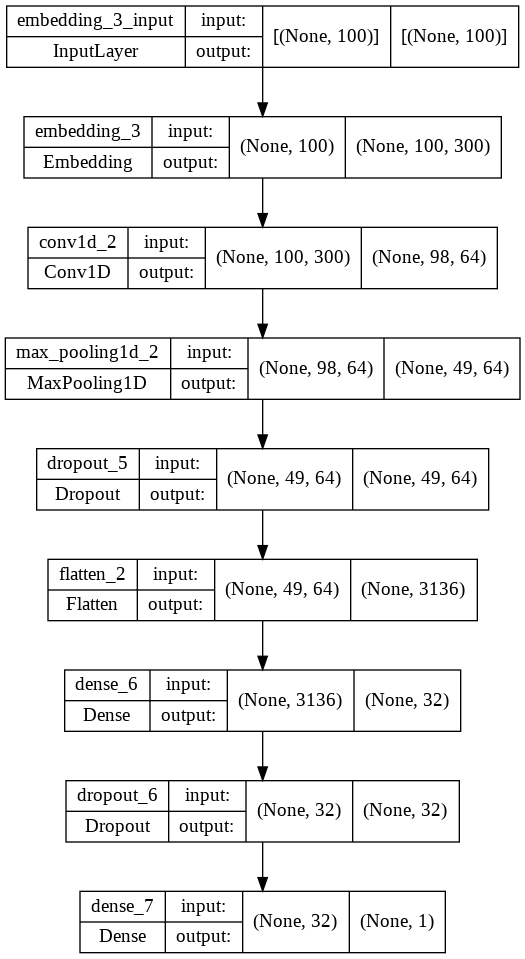

In [ ]:
# summarize the model
from keras.utils.vis_utils import plot_model
plot_model(question_CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)

## Performance Metrics and Accuracy

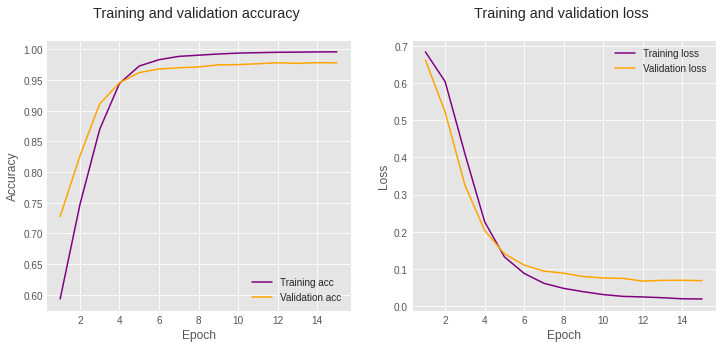

In [ ]:
# create a plot 
plot_history(history)

In [ ]:
# predict
predictions = (question_CNN_model.predict(x_test_CNN) > 0.5).astype("int32")

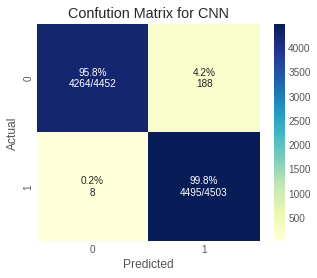

In [ ]:
# Show Confusion Matrix
plot_cm(y_test, predictions, 'Confution Matrix for CNN')

In [ ]:
# Show classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4452
           1       0.96      1.00      0.98      4503

    accuracy                           0.98      8955
   macro avg       0.98      0.98      0.98      8955
weighted avg       0.98      0.98      0.98      8955



# Phase 3 - EDA on Modifications Made by SME

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16679 entries, 0 to 16678
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               16679 non-null  object
 1   answer                 16624 non-null  object
 2   line                   16679 non-null  object
 3   saved                  16679 non-null  bool  
 4   type                   16679 non-null  object
 5   saved.question         1646 non-null   object
 6   saved.type             1646 non-null   object
 7   book_id                16679 non-null  int64 
 8   book_name              16679 non-null  object
 9   chapters.chapter_name  16679 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.3+ MB


In [ ]:
df.drop(['saved.question', 'line', 'type', 'saved.question', 'saved.type','book_id','book_name','chapters.chapter_name'], axis = 1, inplace = True)

In [ ]:
#df.rename(columns = {'ai_generated':'ai_generated_question', 'saved.question':'edited_saved_question', 'saved.answer':'saved_answer'}, inplace = True)

In [ ]:
#df['question'] = df['question'].apply(lambda x: str(x).replace('_', '<ANSWER>',1).replace('_', ''))


In [ ]:
## replace <ANSWER> with actual answer
df['question']= df.apply(lambda x: x['question'].replace('<ANSWER>', str(x['answer'])), axis=1)

In [ ]:
#df

In [ ]:
from nltk import word_tokenize, pos_tag, pos_tag_sents

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tags = pos_tag_sents (map(word_tokenize, df['question'].tolist()))

In [ ]:
tag_only = [[item[1] for item in question] for question in tags]

In [ ]:
df['tag_only'] = tag_only

In [ ]:
#df

In [ ]:
#two dfs
condition = df.saved == True

In [ ]:
#condition

In [ ]:
df_saved = df[condition]
df_unsaved = df[~condition]

In [ ]:
df_saved

In [ ]:
#flatten list of list
flatten_saved_tagsOnly = []
for item in df_saved.tag_only:
    for tags in item:
        flatten_saved_tagsOnly.append(tags)

In [ ]:
#flatten list of list
flatten_unsaved_tagsOnly = []
for item in df_unsaved.tag_only:
    for tags in item:
        flatten_unsaved_tagsOnly.append(tags)

In [ ]:
#new_df = pd.DataFrame({'unsaved_tags': pd.Series(flatten_unsaved_tagsOnly)})

In [ ]:
new_df = pd.DataFrame({'unsaved_tags': pd.Series(flatten_unsaved_tagsOnly), 'saved_tags': pd.Series(flatten_saved_tagsOnly)})

In [ ]:
new_df

,unsaved_tags,saved_tags
0,JJ,JJ
1,$,NN
2,CD,IN
3,NNP,NN
4,$,VBZ
...,...,...
369913,JJ,NaN
369914,NNS,NaN
369915,IN,NaN
369916,NN,NaN


In [ ]:
new_df.dropna(inplace = True)

In [ ]:
new_df_melt = pd.melt(new_df)

In [ ]:
new_df_melt

,variable,value
0,unsaved_tags,JJ
1,unsaved_tags,$
2,unsaved_tags,CD
3,unsaved_tags,NNP
4,unsaved_tags,$
...,...,...
97039,saved_tags,:
97040,saved_tags,.
97041,saved_tags,FW
97042,saved_tags,CD


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

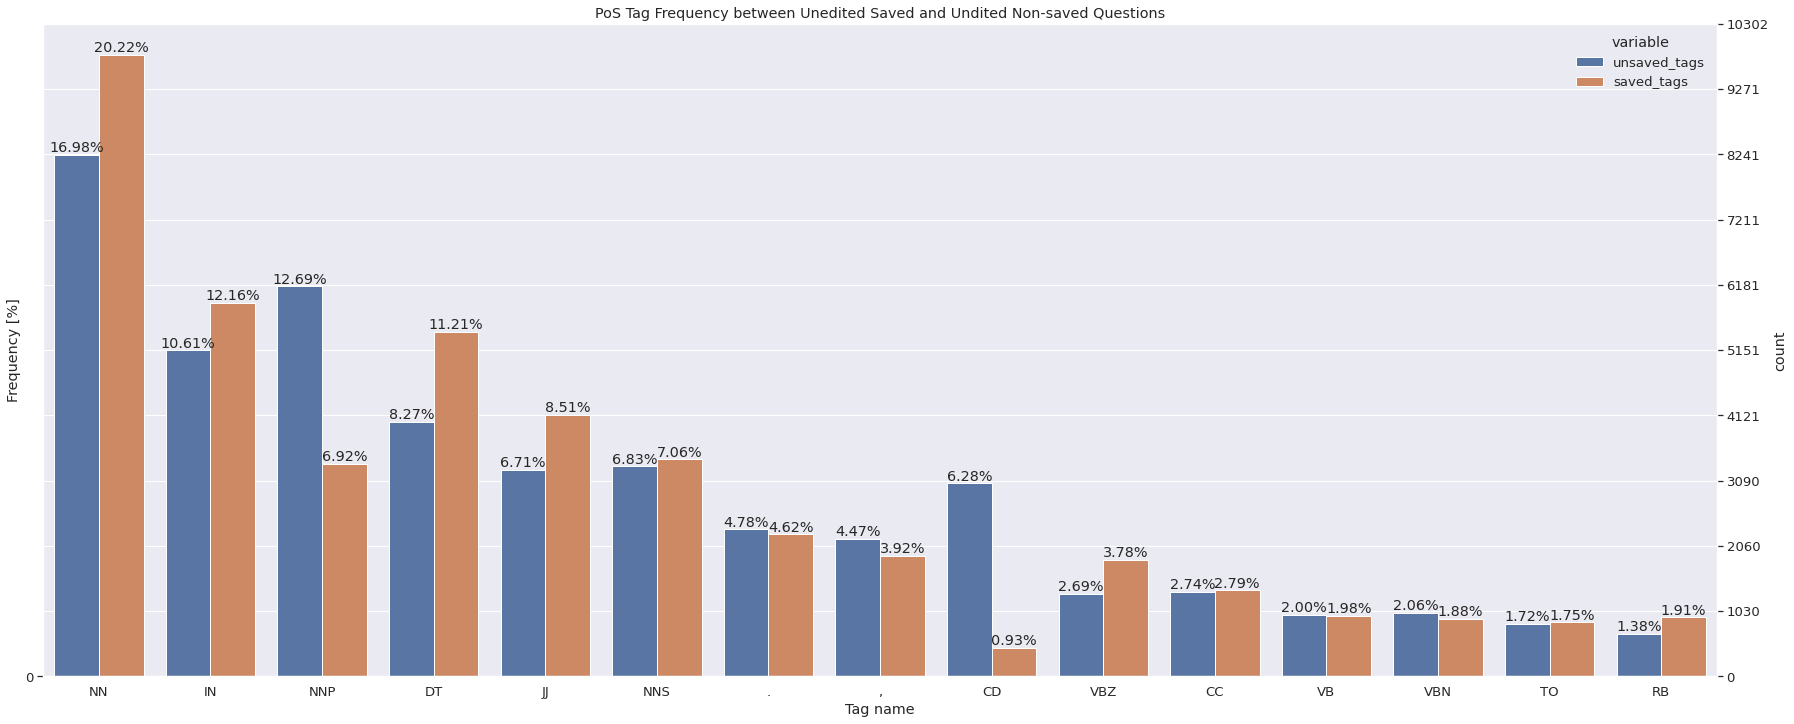

In [ ]:
plt.figure(figsize=(30,12))
sns.set(font_scale = 1.2)

ax = sns.countplot(x="value", data=new_df_melt, hue = 'variable', 
                   order=new_df_melt.value.value_counts().iloc[:15].index)
plt.title('PoS Tag Frequency between Unedited Saved and Undited Non-saved Questions')
plt.xlabel('Tag name')

ncount = len(new_df)

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# # Fix the frequency range to 0-100
# ax2.set_ylim(0,100)
# ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
import spacy
from spacy import displacy
ner = spacy.load("en_core_web_sm")

In [ ]:
df

,question,answer,saved,tag_only
0,Net income under _____________ is unaffected...,Variable Costing,True,"[JJ, NN, IN, NN, VBZ, VBN, IN, NNS, IN, NN, NN..."
1,A _____________ is an authorization form pre...,Voucher,True,"[DT, NN, VBZ, DT, NN, NN, VBN, IN, DT, NN, .]"
2,"In contrast, under _____________ , all fixed ...",Variable Costing,True,"[IN, NN, ,, IN, NN, ,, DT, JJ, NN, NNS, VBP, V..."
3,It is an earnings amount calculated as net inc...,Stock,True,"[PRP, VBZ, DT, NNS, NN, VBD, IN, JJ, NN, JJR, ..."
4,"For example, Nike golf clubs are sold at local...",What's Cooking?,True,"[IN, NN, ,, NNP, NN, NNS, VBP, VBN, IN, JJ, NN..."
...,...,...,...,...
16674,This diagram of a typical parasitic flatworm s...,Gut,False,"[DT, NN, IN, DT, JJ, JJ, NN, VBZ, DT, JJ, NNS,..."
16675,"As you will see, an important property for __...",Lipids,False,"[IN, PRP, MD, VB, ,, DT, JJ, NN, IN, NN, IN, N..."
16676,"Humans have only carotid bodies, which are fou...",Arteries,False,"[NNS, VBP, RB, JJ, NNS, ,, WDT, VBP, VBN, IN, ..."
16677,The _____________ are much more complex in b...,Ciliates,False,"[DT, NN, VBP, RB, RBR, JJ, IN, NN, NN, IN, VBP..."


In [ ]:
questions = df['question'].tolist()
ner_labels = []
for question in questions:
    ner_ai_question = ner(question)
    label_list = []
    for word in ner_ai_question.ents:
        label_list.append(word.label_)
    ner_labels.append(label_list)

In [ ]:
ner_labels

In [ ]:
df['NER_tags'] = ner_labels

In [ ]:
df

In [ ]:
df_saved_ner = df[condition]
df_unsaved_ner = df[~condition]

In [ ]:
#flatten list of list
flatten_saved_nertagsOnly = []
for item in df_saved_ner.NER_tags:
    for tags in item:
        flatten_saved_nertagsOnly.append(tags)

In [ ]:
#flatten list of list
flatten_unsaved_nertagsOnly = []
for item in df_unsaved_ner.NER_tags:
    for tags in item:
        flatten_unsaved_nertagsOnly.append(tags)

In [ ]:
#ner_df = pd.DataFrame({'unsaved_nertags': pd.Series(flatten_unsaved_nertagsOnly)})

In [ ]:
ner_df = pd.DataFrame({'unsaved_nertags': pd.Series(flatten_unsaved_nertagsOnly), 'saved_nertags': pd.Series(flatten_saved_nertagsOnly)})

In [ ]:
ner_df

In [ ]:
ner_df.dropna(inplace = True)

In [ ]:
ner_df_melt = pd.melt(ner_df)

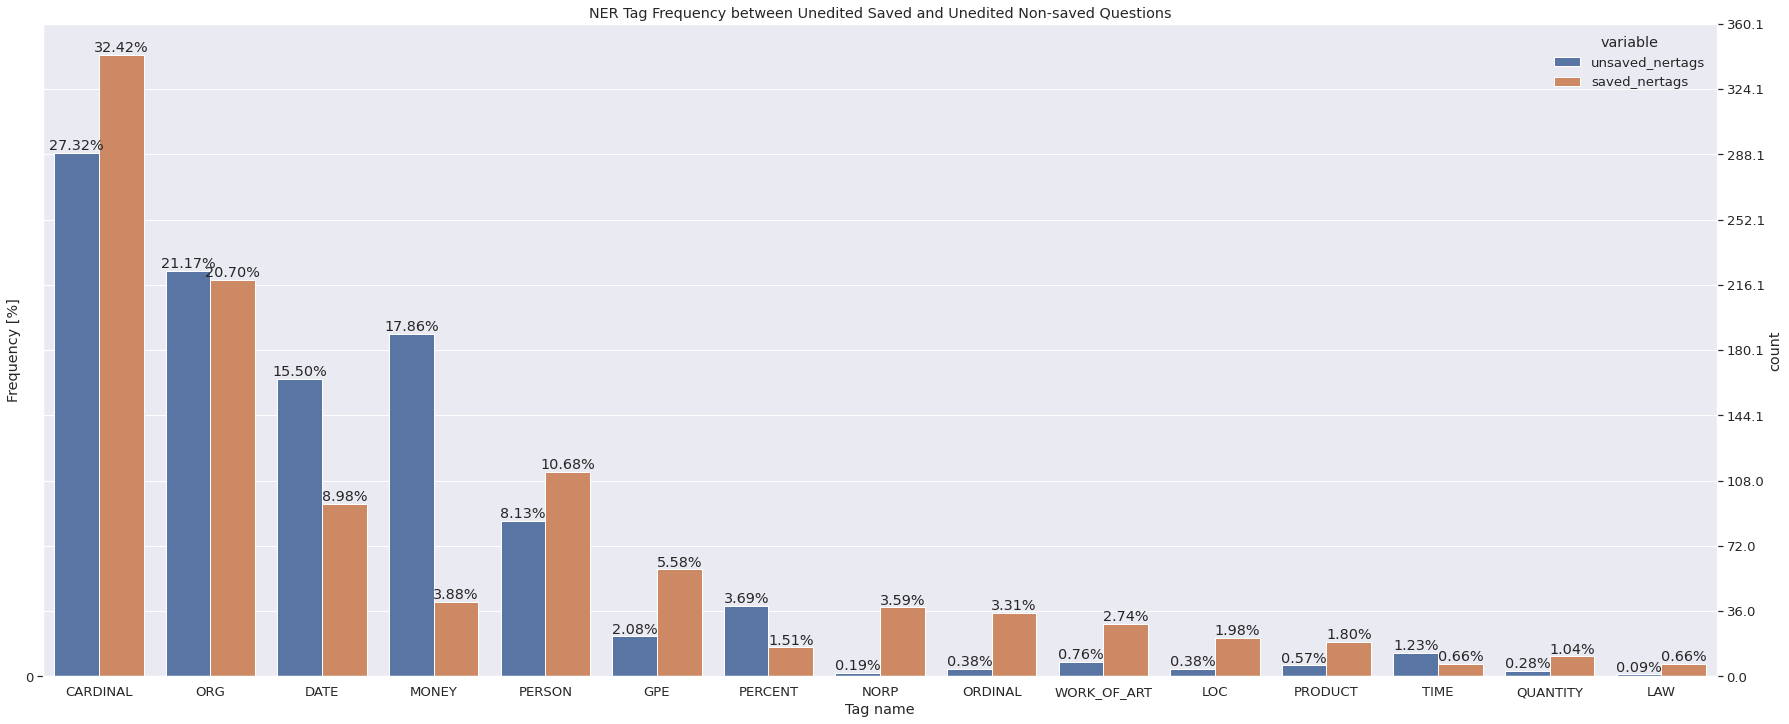

In [ ]:
plt.figure(figsize=(30,12))
sns.set(font_scale = 1.2)

ax = sns.countplot(x="value", data=ner_df_melt, hue = 'variable', 
                   order=ner_df_melt.value.value_counts().iloc[:15].index)
plt.title('NER Tag Frequency between Unedited Saved and Unedited Non-saved Questions')
plt.xlabel('Tag name')

ncount = len(ner_df)

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# # Fix the frequency range to 0-100
# ax2.set_ylim(0,100)
# ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

# Phase 4 - BLEU Metric between Unedited Saved vs. Edited Saved

https://aclanthology.org/P02-1040.pdf

https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

https://www.nltk.org/api/nltk.translate.bleu_score.html 

https://colab.research.google.com/github/gcunhase/NLPMetrics/blob/master/notebooks/bleu.ipynb#scrollTo=0J2_E8zQP6K9

Bleu measures precision: how much the words (and/or n-grams) in the machine generated summaries appeared in the human reference summaries.

In [ ]:
df_copy2 = df_copy.copy()

In [ ]:
# extract cleaned data
df_copy2 = df_copy[df_copy['saved']==True][['q_clean', 'answer', 'saved_q_clean', 'saved']] #'saved.answer',
df_copy2

,q_clean,answer,saved_q_clean,saved
0,net income unaffected changes production le...,Variable Costing,net income variable costing unaffected changes...,True
1,authorization form prepared expenditure,Voucher,authorization form prepared expenditure,True
2,contrast fixed manufacturing costs expensed...,Variable Costing,costing manufacturing costs expensed current...,True
3,earnings amount calculated net income less div...,Stock,amount calculated net income less dividends p...,True
4,example nike golf clubs sold local country clu...,What's Cooking?,due date stated months time factor calculation...,True
...,...,...,...,...
12351,figure narrow zone firebellied toads yello...,Hybrid Zone,narrow zone firebellied toads yellowbellied to...,True
12352,image numbered boxes bundle muscle fibers,3,image numbered boxes bundle muscle fibers,True
12353,doublestranded molecule—that consists two s...,Dna,doublestranded molecule—that consists two sep...,True
12354,atom consists nucleus containing neutrons c...,Protons,atom consists nucleus containing characterist...,True


evaluating a candidate sentence, generated text against one or more reference sentences.

In [ ]:
# AI-generated question
# param hypothesis: a hypothesis sentence
# type: hypotheses (list(list(str))) – a list of hypothesis sentences
candidate = list(df_copy2['q_clean'].str.split().apply(lambda x : [i for i in x]))
candidate[:2] # it is a list

[['net', 'income', 'unaffected', 'changes', 'production', 'levels'],
 ['authorization', 'form', 'prepared', 'expenditure']]

In [ ]:
# SME-edited question
# param references: reference sentences
# type: list_of_references (list(list(list(str)))) – a corpus of lists of reference sentences
reference = list(df_copy2['saved_q_clean'].str.split().apply(lambda x : [i for i in x]))
reference[:2] #list(list(str))

[['net',
  'income',
  'variable',
  'costing',
  'unaffected',
  'changes',
  'production',
  'levels',
  'net',
  'income',
  'variable',
  'costing',
  'unaffected',
  'changes',
  'production',
  'levels',
  'instead',
  'closely',
  'tied',
  'changes'],
 ['authorization', 'form', 'prepared', 'expenditure']]

In [ ]:
# turn into (list(list(list(str))))
# https://stackoverflow.com/questions/6614891/turning-a-list-into-nested-lists-in-python
reference_list = [reference[i:i+1] for i in range(0, len(reference), 1)]
reference_list[:2]

[[['net',
   'income',
   'variable',
   'costing',
   'unaffected',
   'changes',
   'production',
   'levels',
   'net',
   'income',
   'variable',
   'costing',
   'unaffected',
   'changes',
   'production',
   'levels',
   'instead',
   'closely',
   'tied',
   'changes']],
 [['authorization', 'form', 'prepared', 'expenditure']]]

In [ ]:
# Calculate a single corpus-level BLEU score for all the hypotheses and their respective references
score_ref_a = bleu.corpus_bleu(reference_list, candidate)
print("BLEU score for all the hypotheses and their respective references: {}".format(score_ref_a))

BLEU score for all the hypotheses and their respective references: 0.4389351330368957
